In [155]:
!pip install geopandas
import geopandas as gpd
import numpy as np

In [156]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Load shapefiles

In [225]:
# Read shapefiles
subset_pred = "all_data_pred" # random_subset_pred, balanced_subset_pred, all_data_pred
site = "braatan_40m_20230605_sun"  #braatan_40m_20230605_sun [18:19], krakstad_202304_sun, ortho_hobol_042222_mavic_sun [0:1], galbyveien_20230504_sun [19:20]

#
predpath = "/content/drive/MyDrive/NOVA_course_deep_learning/data/tiles/10m_" + str(site) + "/" + str(subset_pred) + "_predictions.shp"
pred_boxes = gpd.read_file(predpath)

ref_boxes = gpd.read_file('/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/test_annotations2_sun.geojson')
aois = gpd.read_file('/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/drone_acquisitions.geojson')[19:20]  #index drone aquisions for each site


if site == "galbyveien_20230504_sun":
  aois = gpd.read_file('/content/drive/MyDrive/NOVA_course_deep_learning/data/map_data/aois.geojson') # Shapefile containing multiple AOIs



In [226]:
aois

,id,aoi_name,geometry
11,NaN,braatan2,"MULTIPOLYGON (((610834.611 6622639.058, 610869..."
12,NaN,braatan2,"MULTIPOLYGON (((610826.616 6622610.183, 610857..."
13,NaN,braatan1,"MULTIPOLYGON (((611069.310 6622561.150, 611096..."
14,NaN,braatan1,"MULTIPOLYGON (((611083.816 6622534.933, 611109..."


# plots

<ipython-input-227-a2606e21b8a9>:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


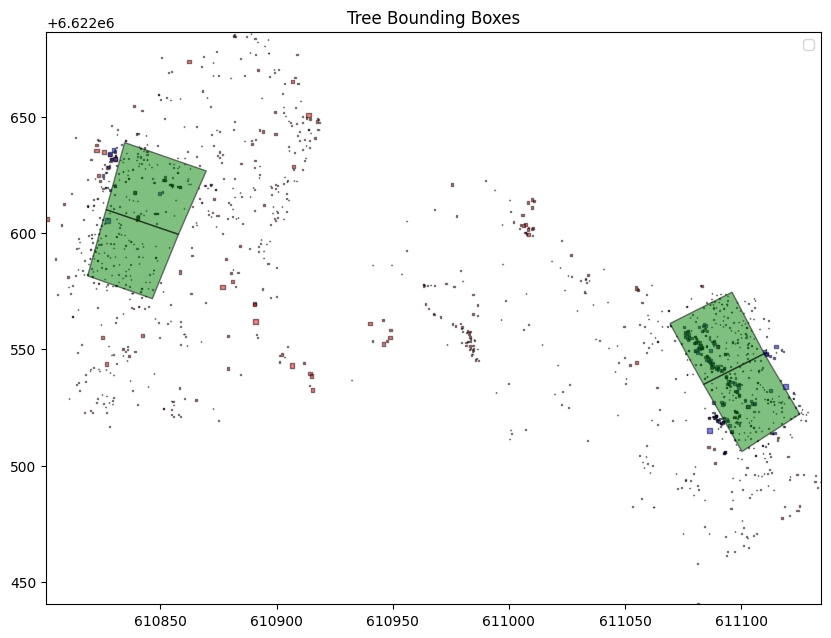

In [227]:
import matplotlib.pyplot as plt


#for aoi in aois.iterrows():
#    aoi_geom = aoi[1].geometry
#    ref_boxes_aoi = ref_boxes[ref_boxes.geometry.within(aoi_geom)]

# Plotting the shapefiles
fig, ax = plt.subplots(figsize=(10, 10))

# Plot predicted boxes
pred_boxes.plot(ax=ax, color='red', edgecolor='black', alpha=0.5, label='Predicted Boxes')

# Plot reference boxes
ref_boxes.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5, label='Reference Boxes')

# Plot AOI
aois.plot(ax=ax, color='green', edgecolor='black', alpha=0.5, label='AOI')

# Zoom to the extent of predicted boxes
ax.set_xlim(pred_boxes.total_bounds[0], pred_boxes.total_bounds[2])
ax.set_ylim(pred_boxes.total_bounds[1], pred_boxes.total_bounds[3])

# Zoom to the extent of ref boxes
#ax.set_xlim(ref_boxes_aoi.total_bounds[0], ref_boxes_aoi.total_bounds[2])
#ax.set_ylim(ref_boxes_aoi.total_bounds[1], ref_boxes_aoi.total_bounds[3])

# Set plot title and legend
plt.title('Tree Bounding Boxes')
plt.legend()

# Display the plot
plt.show()

# Compute residuals

In [228]:
# Initialize lists to store residuals for each AOI
residuals = []

# Compute residuals for each AOI
for aoi in aois.iterrows():
    aoi_geom = aoi[1].geometry
    pred_within_aoi = pred_boxes[pred_boxes.geometry.within(aoi_geom)]
    ref_within_aoi = ref_boxes[ref_boxes.geometry.within(aoi_geom)]

    num_pred_within_aoi = len(pred_within_aoi)
    num_ref_within_aoi = len(ref_within_aoi)

    residual = num_pred_within_aoi - num_ref_within_aoi
    residuals.append(residual)


In [229]:
residuals

[-75, -95, -155, -111]

# Compute RMSE

In [230]:
# Compute RMSE
rmse = np.sqrt(np.mean(np.power(residuals, 2)))
bias= np.mean(residuals)
print("the RMSE is: "+ str(rmse))
print("the bias is: "+ str(bias))

the RMSE is: 112.91146974510606
the bias is: -109.0


# Now we are going to per hectare values

In [231]:
# Initialize lists to store the number of boxes per hectare for each AOI
box_density = []

# Compute the number of boxes per hectare for each AOI
for aoi in aois.iterrows():
    aoi_geom = aoi[1].geometry
    pred_within_aoi = pred_boxes[pred_boxes.geometry.within(aoi_geom)]
    ref_within_aoi = ref_boxes[ref_boxes.geometry.within(aoi_geom)]

    area = aoi_geom.area  # Area in square meters
    area_ha = area / 10000  # Convert area to hectares
    num_pred_within_aoi = len(pred_within_aoi)
    num_ref_within_aoi = len(ref_within_aoi)

    pred_density = num_pred_within_aoi / area_ha
    ref_density = num_ref_within_aoi / area_ha

    box_density.append((pred_density, ref_density))

In [232]:
box_density

[(229.4909157269947, 946.650027373853),
 (150.86094644815063, 1174.5602259177442),
 (440.11386917553403, 2189.2843748731693),
 (342.68167736720625, 1531.3587457347028)]

In [233]:
site

'braatan_40m_20230605_sun'

In [234]:
subset_pred

'all_data_pred'

In [235]:
# Compute RMSE of box density
pred_densities, ref_densities = zip(*box_density)
residuals = np.array(pred_densities) - np.array(ref_densities)
rmse = np.sqrt(np.mean(np.power(residuals, 2)))
bias = np.mean(residuals)

rmse_rel= rmse/np.mean(ref_densities)*100
bias_rel= bias/np.mean(ref_densities)*100

round(rmse,2), round(rmse_rel,2), round(bias,2), round(bias_rel,2)

(1228.29, 84.1, -1169.68, -80.09)

In [ ]:

# Compute RMSE of box density
pred_densities, ref_densities = zip(*box_density)
residuals = np.array(pred_densities) - np.array(ref_densities)
rmse = np.sqrt(np.mean(np.power(residuals, 2)))
bias = np.mean(residuals)

rmse_rel= rmse/np.mean(ref_densities)*100
bias_rel= bias/np.mean(ref_densities)*100

print("RMSE of box density (boxes/ha):"+ str(round(rmse,2)))
print("relative RMSE of box density (%):"+ str(round(rmse_rel,2)))

print("bias of box density (boxes/ha):"+ str(round(bias,2)))
print("relative bias of box density (%):"+ str(round(bias_rel,2)))


RMSE of box density (boxes/ha):20.7
relative RMSE of box density (%):11.01
bias of box density (boxes/ha):20.7
relative bias of box density (%):11.01


In [ ]:
round(1.123, 2)

1.12